# Journal Article Selection
This project aims to explore how effective machine learning classifier is at selecting relevant journal articles related to invasive silver and bighead carp.

In [2]:
# import libraries
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\redinger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Date Cleaning:
Selected articles were indicated, but irrelevant articles were not. 

In [3]:
# Create new column names because text file has no header
col_names = ["Type", "Author", "Year", "Title", "Journal Name", "Volume", "Issue", "Pages", "URL", "Keywords", "Abstract", "DOI", "PDF Name"]

# Convert text files into a dataframe
silver_yes = pd.read_csv('Hypopthalmichthys_molitrix_yes.txt', sep = '\t', header = None, dtype = str, names = col_names, quotechar = '"')
silver_all = pd.read_csv('Hypopthalmichthys_molitrix_all.txt', sep = '\t', header = None, dtype = str, names = col_names, quotechar = '"')
bighead_yes = pd.read_csv('Hypopthalmichthys_nobilis_yes.txt', sep = '\t', header = None, dtype = str, names = col_names, quotechar = '"')
bighead_all = pd.read_csv('Hypopthalmichthys_nobilis_all.txt', sep = '\t', header = None, dtype = str, names = col_names, quotechar = '"')

# Check entries of selected articles
print(len(silver_yes))
print(len(silver_all))
print(len(bighead_yes))
print(len(bighead_all))


123
444
110
197


In [6]:
# Combine data with selected articles
carp_yes = pd.concat([silver_yes, bighead_yes], ignore_index = True)

# Combine all article - duplicates removed in next step to get irrelevant articles
carp_concat = pd.concat([silver_yes, silver_all, bighead_yes, bighead_all], ignore_index = True)

print(len(carp_yes))
print(len(carp_concat))


233
874


In [7]:
# Drop duplicates to get unselected articles
carp_no = carp_concat.drop_duplicates(keep = False, ignore_index = True)

print(len(carp_no))


408


In [8]:
# subset and select by columns
columns = ["Author", "Year", "Title", "Journal Name", "Volume", "Issue", "Pages", "Abstract"]

carp_yes = carp_yes[columns]
carp_no = carp_no[columns]


In [9]:
# add category columns
carp_yes['categories'] = 'yes'
carp_no['categories'] = 'no'


In [10]:
# combine df
carp_all = pd.concat([carp_yes, carp_no], ignore_index = True)

print(len(carp_all))

641


In [9]:
# Export to csv files
carp_all.to_csv('hypopthalmichthys_selected_articles.csv', index = False)


#### Data Prep

In [23]:
# Import csv files
carp_file = pd.read_csv('hypopthalmichthys_selected_articles.csv', dtype = str)

print(len(carp_file))


641


In [24]:
# Drop any abstracts with NAs
carp_file.dropna(subset = ['Abstract'], inplace = True)

print(len(carp_file))


641


In [25]:
# Create new encoding for category column
label_encoder = LabelEncoder()
carp_file['encoding'] = label_encoder.fit_transform(carp_file['categories'])
carp_file.head()


,Author,Year,Title,Journal Name,Volume,Issue,Pages,Abstract,categories,encoding
0,"Aldridge, C. A., and E. C. Boone",2022,Simple models to quickly estimate the probable...,River Research and Applications,38,6,1154-1166,Species distribution models provide biologists...,yes,1
1,"Banan, A., A. Nasiri, and A. Taheri-Garavand",2020,Deep learning-based appearance features extrac...,Aquacultural Engineering,89,NaN,NaN,Fish species identification is vital for aquac...,yes,1
2,"Barnes, M. A., W. L. Chadderton, C. L. Jerde, ...",2021,Environmental conditions influence edna partic...,Environmental DNA,3,3,643-653,Knowledge about the size of environmental DNA ...,yes,1
3,"Behera, B. K., A. K. Bera, P. Paria, A. Das, P...",2018,Identification and pathogenicity of plesiomona...,Aquaculture,493,NaN,314-318,Plesiomonas shigelloides was isolated from dis...,yes,1
4,"Borland, L. K., C. J. Mulcahy, B. A. Bennie, D...",2020,Using markov chains to quantitatively assess m...,Natural Resource Modeling,33,4,NaN,Natural resource managers use barriers to dete...,yes,1


#### Text Processing

In [26]:
# Removal of HTML tags and whitespace
carp_basic_clean = carp_file.copy()

# Function to remove HTML tags
def basic_clean(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.strip()
    return text
    
carp_basic_clean['Title'] = carp_basic_clean['Title'].apply(basic_clean)
carp_basic_clean['Abstract'] = carp_basic_clean['Abstract'].apply(basic_clean)


In [27]:
# Remove punctuation, remove special characters, and remove stopwords
carp_advanced_clean = carp_basic_clean.copy()

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to clean text
def advanced_clean(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)

    # Function to remove stopwords from text
    def remove_stopwords(text):
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Filter out stopwords
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        # Reconstruct the text without stopwords
        text_without_stopwords = ' '.join(filtered_tokens)
        return text_without_stopwords

    text = remove_stopwords(text)
    
    return text

carp_advanced_clean['Title'] = carp_advanced_clean['Title'].apply(advanced_clean)
carp_advanced_clean['Abstract'] = carp_advanced_clean['Abstract'].apply(advanced_clean)



In [28]:
# Stemming
carp_stem = carp_advanced_clean.copy()

stemmer = SnowballStemmer(language = 'english')
def stem_words(text):
    text = " ".join([stemmer.stem(word) for word in text.split()])
    return text
    
carp_stem['Title'] = carp_stem['Title'].apply(stem_words)
carp_stem['Abstract'] = carp_stem['Abstract'].apply(stem_words)


In [29]:
# Lemmatize
carp_lemm = carp_advanced_clean.copy()

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text
    
carp_lemm['Title'] = carp_lemm['Title'].apply(stem_words)
carp_lemm['Abstract'] = carp_lemm['Abstract'].apply(stem_words)


In [30]:
# Remove numerical values
carp_no_nums = carp_advanced_clean.copy()

# Function to remove HTML tags
def remove_digits(text):
    text = re.sub(r'\d+', '', text)
    return text
    
carp_no_nums['Title'] = carp_no_nums['Title'].apply(remove_digits)
carp_no_nums['Abstract'] = carp_no_nums['Abstract'].apply(remove_digits)


In [31]:
carp_basic_clean['Abstract'].iloc[1]

"Fish species identification is vital for aquaculture and fishery industries, stock management of water bodies and environmental monitoring of aquatics. Traditional fish species identification approaches are costly, time consuming, expert-based and unsuitable for large-scale applications. Hence, in this study, a deep learning neural network as a smart, real-time and non-destructive method was developed and applied to automate the identification of four economically important carp species namely common carp (Cyprinus carpio), grass carp (Ctenopharingodon idella), bighead carp (Hypophtalmichthys nobilis) and silver carp (Hypophthalmichthys molitrix). The obtained results proved that our approach, evaluated through 5-fold cross-validation, achieved the highest possible accuracy of 100 %. The achieved high level of classification accuracy was due to the ability of the suggested deep model to build a hierarchy of self-learned features, which was in accordance with the hierarchy of these fis

In [32]:
carp_advanced_clean['Abstract'].iloc[1]


'fish species identification vital aquaculture fishery industries stock management water bodies environmental monitoring aquatics traditional fish species identification approaches costly time consuming expertbased unsuitable largescale applications hence study deep learning neural network smart realtime nondestructive method developed applied automate identification four economically important carp species namely common carp cyprinus carpio grass carp ctenopharingodon idella bighead carp hypophtalmichthys nobilis silver carp hypophthalmichthys molitrix obtained results proved approach evaluated 5fold crossvalidation achieved highest possible accuracy 100 achieved high level classification accuracy due ability suggested deep model build hierarchy selflearned features accordance hierarchy fishs identification keys conclusion proposed convolutional neural network cnnbased method single generic trained architecture promising performance fish species identification'

In [33]:
carp_stem['Abstract'].iloc[1]

'fish speci identif vital aquacultur fisheri industri stock manag water bodi environment monitor aquat tradit fish speci identif approach cost time consum expertbas unsuit largescal applic henc studi deep learn neural network smart realtim nondestruct method develop appli autom identif four econom import carp speci name common carp cyprinus carpio grass carp ctenopharingodon idella bighead carp hypophtalmichthi nobili silver carp hypophthalmichthi molitrix obtain result prove approach evalu 5fold crossvalid achiev highest possibl accuraci 100 achiev high level classif accuraci due abil suggest deep model build hierarchi selflearn featur accord hierarchi fish identif key conclus propos convolut neural network cnnbase method singl generic train architectur promis perform fish speci identif'

In [34]:
carp_lemm['Abstract'].iloc[1]

'fish speci identif vital aquacultur fisheri industri stock manag water bodi environment monitor aquat tradit fish speci identif approach cost time consum expertbas unsuit largescal applic henc studi deep learn neural network smart realtim nondestruct method develop appli autom identif four econom import carp speci name common carp cyprinus carpio grass carp ctenopharingodon idella bighead carp hypophtalmichthi nobili silver carp hypophthalmichthi molitrix obtain result prove approach evalu 5fold crossvalid achiev highest possibl accuraci 100 achiev high level classif accuraci due abil suggest deep model build hierarchi selflearn featur accord hierarchi fish identif key conclus propos convolut neural network cnnbase method singl generic train architectur promis perform fish speci identif'

In [35]:
carp_no_nums['Abstract'].iloc[1]

'fish species identification vital aquaculture fishery industries stock management water bodies environmental monitoring aquatics traditional fish species identification approaches costly time consuming expertbased unsuitable largescale applications hence study deep learning neural network smart realtime nondestructive method developed applied automate identification four economically important carp species namely common carp cyprinus carpio grass carp ctenopharingodon idella bighead carp hypophtalmichthys nobilis silver carp hypophthalmichthys molitrix obtained results proved approach evaluated fold crossvalidation achieved highest possible accuracy  achieved high level classification accuracy due ability suggested deep model build hierarchy selflearned features accordance hierarchy fishs identification keys conclusion proposed convolutional neural network cnnbased method single generic trained architecture promising performance fish species identification'

#### Machine Learning Models

In [49]:
# Balance data categories
print(len(carp_file1))

# Count the number of rows in each category
category_counts = carp_file1['encoding'].value_counts()

# Find the minority category
minority_category = category_counts.idxmin()

# Get the size of the minority category
minority_category_size = category_counts[minority_category]

# Sample rows from the majority category to match the size of the minority category
majority_category_rows = carp_file1[carp_file1['encoding'] != minority_category]
balanced_majority_category_rows = majority_category_rows.sample(n=minority_category_size, random_state=42)

# Get the minority category rows
minority_category_rows = carp_file1[carp_file1['encoding'] == minority_category]

# Concatenate the minority and balanced majority category rows
carp_file1 = pd.concat([minority_category_rows, balanced_majority_category_rows])

print(len(carp_file1))

,Author,Year,Title,Journal Name,Volume,Issue,Pages,Abstract,categories,encoding
0,"Aldridge, C. A., and E. C. Boone",2022,simpl model quick estim probabl rang datalimit...,River Research and Applications,38,6,1154-1166,speci distribut model provid biologist insight...,yes,1
1,"Banan, A., A. Nasiri, and A. Taheri-Garavand",2020,deep learningba appear featur extract autom ca...,Aquacultural Engineering,89,NaN,NaN,fish speci identif vital aquacultur fisheri in...,yes,1
2,"Barnes, M. A., W. L. Chadderton, C. L. Jerde, ...",2021,environ condit influenc edna particl size dist...,Environmental DNA,3,3,643-653,knowledg size environ dna edna ednabear partic...,yes,1
3,"Behera, B. K., A. K. Bera, P. Paria, A. Das, P...",2018,identif pathogen plesiomona shigelloid silver ...,Aquaculture,493,NaN,314-318,plesiomona shigelloid isol disea silver carp k...,yes,1
4,"Borland, L. K., C. J. Mulcahy, B. A. Bennie, D...",2020,use markov chain quantit assess movement patte...,Natural Resource Modeling,33,4,NaN,natur resourc manag use barrier deter movement...,yes,1
...,...,...,...,...,...,...,...,...,...,...
299,"Fang, D. A., Y. F. Zhou, P. Ren, Y. X. Peng, X...",2022,status silver carp resourc complementari mecha...,Frontiers in Marine Science,8,NaN,NaN,global climat environ variabl induc fish adapt...,no,0
388,"Lin, C., Z. D. Deng, X. Shi, H. Dai, J. Wang, ...",2022,mutual promot constrain disentangl superimpo e...,Freshwater Biology,67,8,1468-1480,global climat chang speci inva human activ con...,no,0
326,"Hamilton, M. G., W. Mekkawy, B. K. Barman, M. ...",2021,genet relationship among founder silver carp h...,Aquaculture,540,NaN,NaN,silver carp hypophthalmichthi molitrix import ...,no,0
301,"Fang, M. X., S. B. Xiong, Y. Hu, T. Yin, and J...",2019,vitro pepsin digest silver carp hypophthalmich...,Food Hydrocolloids,95,NaN,152-160,addit microbi transglutamina mtgase surimi gel...,no,0


In [108]:
# X = carp_file1[['Title', 'Abstract']]
# y = carp_file1['encoding']
carp_file1["TitleAbstract"] = carp_file1["Title"] + ' ' + carp_file1["Abstract"]

# Split the data into training and test sets
X_train_title, X_test_title, y_train, y_test = train_test_split(carp_file1['Title'], carp_file1['encoding'], test_size=0.2, random_state=42)
X_train_abstract, X_test_abstract, _, _ = train_test_split(carp_file1['Abstract'], carp_file1['encoding'], test_size=0.2, random_state=42)
X_train_combined, X_test_combined, _, _ = train_test_split(carp_file1['TitleAbstract'], carp_file1['encoding'], test_size=0.2, random_state=42)

In [113]:
# Vectorize text data
vectorizer = TfidfVectorizer()

X_train_title_vec = vectorizer.fit_transform(X_train_title)
X_test_title_vec = vectorizer.transform(X_test_title)

X_train_abstract_vec = vectorizer.fit_transform(X_train_abstract)
X_test_abstract_vec = vectorizer.transform(X_test_abstract)

X_train_combined_vec = vectorizer.fit_transform(X_train_combined)
X_test_combined_vec = vectorizer.transform(X_test_combined)

0.6464646464646465
0.6607387140902874
0.6276595744680851


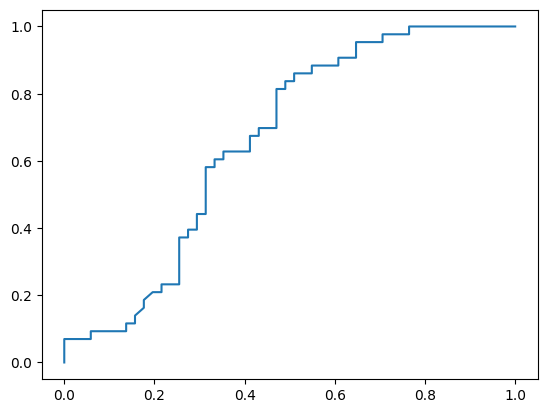

In [110]:
# Fit logistic regression model
mod = LogisticRegression()
mod.fit(X_train_title_vec, y_train)

# Predict probabilities and classes
y_pred = mod.predict(X_test_title_vec)
y_pred_prob = mod.predict_proba(X_test_title_vec)[:, 1]

# Calculate metrics
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f1)
print(auc)
print(accuracy)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)


0.7
0.7168262653898769
0.6808510638297872


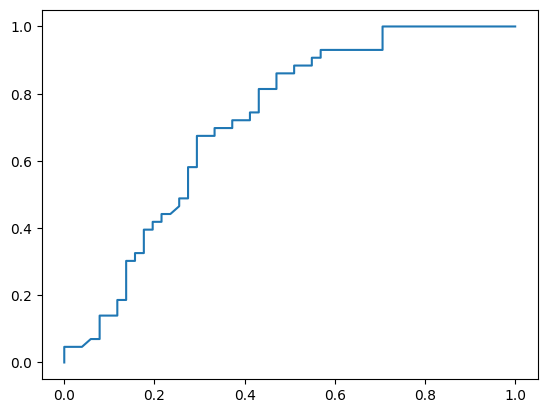

In [111]:
# Fit logistic regression model
mod = LogisticRegression()
mod.fit(X_train_abstract_vec, y_train)

# Predict probabilities and classes
y_pred = mod.predict(X_test_abstract_vec)
y_pred_prob = mod.predict_proba(X_test_abstract_vec)[:, 1]

# Calculate metrics
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f1)
print(auc)
print(accuracy)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)

0.6990291262135923
0.7250341997264023
0.6702127659574468


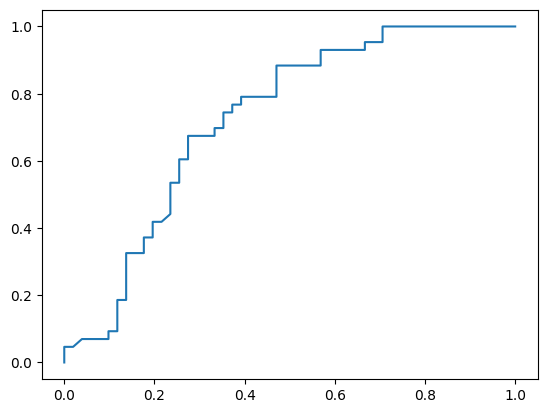

In [114]:
# Fit logistic regression model
mod = LogisticRegression()
mod.fit(X_train_combined_vec, y_train_combined)

# Predict probabilities and classes
y_pred = mod.predict(X_test_combined_vec)
y_pred_prob = mod.predict_proba(X_test_combined_vec)[:, 1]

# Calculate metrics
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f1)
print(auc)
print(accuracy)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)

In [ ]:
for df in df_list:
        # Count the number of rows in each category
        category_counts = df['encoding'].value_counts()

        # Find the minority category
        minority_category = category_counts.idxmin()

        # Get the size of the minority category
        minority_category_size = category_counts[minority_category]

        # Sample rows from the majority category to match the size of the minority category
        majority_category_rows = df[df['encoding'] != minority_category]
        balanced_majority_category_rows = majority_category_rows.sample(n=minority_category_size, random_state=42)

        # Get the minority category rows
        minority_category_rows = df[df['encoding'] == minority_category]

        # Concatenate the minority and balanced majority category rows
        balanced_df = pd.concat([minority_category_rows, balanced_majority_category_rows])
        
        balanced_dfs.append(balanced_df)

In [36]:
# Iterate over datasets to collect metrics
datasets = [carp_basic_clean, carp_advanced_clean, carp_stem, carp_lemm, carp_no_nums]

In [37]:
balanced_dfs = []

for df in datasets:
    # Count the number of rows in each category
    category_counts = df['encoding'].value_counts()

    # Find the minority category
    minority_category = category_counts.idxmin()

    # Get the size of the minority category
    minority_category_size = category_counts[minority_category]

    # Sample rows from the majority category to match the size of the minority category
    majority_category_rows = df[df['encoding'] != minority_category]
    balanced_majority_category_rows = majority_category_rows.sample(n=minority_category_size, random_state=42)

    # Get the minority category rows
    minority_category_rows = df[df['encoding'] == minority_category]

    # Concatenate the minority and balanced majority category rows
    balanced_df = pd.concat([minority_category_rows, balanced_majority_category_rows])

    balanced_dfs.append(balanced_df)

In [ ]:
def classification_pipeline(data):
    def process_text_data(text_data):
        vectorizer = TfidfVectorizer()
        text_vec = vectorizer.fit_transform(text_data)
        return text_vec, vectorizer
    
    def evaluate_model(model, X_test_vec, y_test):
        y_pred = model.predict(X_test_vec)
        y_pred_prob = model.predict_proba(X_test_vec)[:, 1]
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_prob)
        accuracy = accuracy_score(y_test, y_pred)
        return f1, auc, accuracy, y_pred_prob
    
    # Concatenate Title and Abstract
    data["TitleAbstract"] = data["Title"] + ' ' + data["Abstract"]
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data['TitleAbstract'], data['encoding'], test_size=0.2, random_state=42)

    # Process title data
    X_train_title, X_test_title = X_train.apply(lambda x: x.split(' ')[0]), X_test.apply(lambda x: x.split(' ')[0])
    X_train_title_vec, title_vectorizer = process_text_data(X_train_title)
    X_test_title_vec = title_vectorizer.transform(X_test_title)
    
    # Process abstract data
    X_train_abstract, X_test_abstract = X_train.apply(lambda x: ' '.join(x.split(' ')[1:])), X_test.apply(lambda x: ' '.join(x.split(' ')[1:]))
    X_train_abstract_vec, abstract_vectorizer = process_text_data(X_train_abstract)
    X_test_abstract_vec = abstract_vectorizer.transform(X_test_abstract)
    
    # Process combined data
    X_train_combined_vec, combined_vectorizer = process_text_data(X_train)
    X_test_combined_vec = combined_vectorizer.transform(X_test)
    
    # Fit logistic regression model for title
    mod_title = LogisticRegression()
    mod_title.fit(X_train_title_vec, y_train)
    f1_title, auc_title, accuracy_title, _ = evaluate_model(mod_title, X_test_title_vec, y_test)
    
    # Fit logistic regression model for abstract
    mod_abstract = LogisticRegression()
    mod_abstract.fit(X_train_abstract_vec, y_train)
    f1_abstract, auc_abstract, accuracy_abstract, _ = evaluate_model(mod_abstract, X_test_abstract_vec, y_test)
    
    # Fit logistic regression model for combined
    mod_combined = LogisticRegression()
    mod_combined.fit(X_train_combined_vec, y_train)
    f1_combined, auc_combined, accuracy_combined, _ = evaluate_model(mod_combined, X_test_combined_vec, y_test)
    
    # Organize data
    data = {
        "Metric": ["F1 Score", "AUC", "Accuracy"],
        "Title": [f1_title, auc_title, accuracy_title],
        "Abstract": [f1_abstract, auc_abstract, accuracy_abstract],
        "Title & Abstract": [f1_combined, auc_combined, accuracy_combined]
    }
    
    evaluation_results = pd.DataFrame(data)
    
    return evaluation_results

In [69]:
# Create an empty dataframe to collect the results
results_df = pd.DataFrame(columns=["Metric", "Title", "Abstract", "Title & Abstract"])

for data in balanced_dfs:
    results_df = pd.concat([results_df, pd.DataFrame(classification_pipeline(data))], ignore_index=True)

results_df["Data Cleaning"] = ["Basic"]*3 + ["Advanced"]*3 + ["Stemming"]*3 + ["Lemmenization"]*3 + ["Removing Number"]*3

results_df = results_df[['Data Cleaning', 'Metric', 'Title', 'Abstract', 'Title & Abstract']]
# Print or return the dataframe
results_df

C:\Users\redinger\AppData\Local\Temp\1\ipykernel_3348\590345411.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(classification_pipeline(data))], ignore_index=True)


,Data Cleaning,Metric,Title,Abstract,Title & Abstract
0,Basic,F1 Score,0.490909,0.711538,0.711538
1,Basic,AUC,0.466028,0.716598,0.714318
2,Basic,Accuracy,0.404255,0.680851,0.680851
3,Advanced,F1 Score,0.495575,0.699029,0.705882
4,Advanced,AUC,0.433425,0.702918,0.702918
5,Advanced,Accuracy,0.393617,0.670213,0.680851
6,Stemming,F1 Score,0.535714,0.725490,0.737864
7,Stemming,AUC,0.463748,0.740766,0.738030
8,Stemming,Accuracy,0.446809,0.702128,0.712766
9,Lemmenization,F1 Score,0.535714,0.725490,0.737864


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split

def classification_pipeline(data):
    def process_text_data(text_data):
        vectorizer = TfidfVectorizer()
        text_vec = vectorizer.fit_transform(text_data)
        return text_vec, vectorizer
    
    def evaluate_model(model, X_test_vec, y_test):
        y_pred = model.predict(X_test_vec)
        y_pred_prob = model.predict_proba(X_test_vec)[:, 1]
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_prob)
        accuracy = accuracy_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        return f1, auc, accuracy, fpr, tpr
    
    # Concatenate Title and Abstract
    data["TitleAbstract"] = data["Title"] + ' ' + data["Abstract"]
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data['TitleAbstract'], data['encoding'], test_size=0.2, random_state=42)

    # Process title data
    X_train_title, X_test_title = X_train.apply(lambda x: x.split(' ')[0]), X_test.apply(lambda x: x.split(' ')[0])
    X_train_title_vec, title_vectorizer = process_text_data(X_train_title)
    X_test_title_vec = title_vectorizer.transform(X_test_title)
    
    # Process abstract data
    X_train_abstract, X_test_abstract = X_train.apply(lambda x: ' '.join(x.split(' ')[1:])), X_test.apply(lambda x: ' '.join(x.split(' ')[1:]))
    X_train_abstract_vec, abstract_vectorizer = process_text_data(X_train_abstract)
    X_test_abstract_vec = abstract_vectorizer.transform(X_test_abstract)
    
    # Process combined data
    X_train_combined_vec, combined_vectorizer = process_text_data(X_train)
    X_test_combined_vec = combined_vectorizer.transform(X_test)
    
    # Fit logistic regression model for title
    mod_title = LogisticRegression()
    mod_title.fit(X_train_title_vec, y_train)
    f1_title, auc_title, accuracy_title, fpr_title, tpr_title = evaluate_model(mod_title, X_test_title_vec, y_test)
    
    # Fit logistic regression model for abstract
    mod_abstract = LogisticRegression()
    mod_abstract.fit(X_train_abstract_vec, y_train)
    f1_abstract, auc_abstract, accuracy_abstract, fpr_abstract, tpr_abstract = evaluate_model(mod_abstract, X_test_abstract_vec, y_test)
    
    # Fit logistic regression model for combined
    mod_combined = LogisticRegression()
    mod_combined.fit(X_train_combined_vec, y_train)
    f1_combined, auc_combined, accuracy_combined, fpr_combined, tpr_combined = evaluate_model(mod_combined, X_test_combined_vec, y_test)
    
    # Organize data
    data = {
        "Metric": ["F1 Score", "AUC", "Accuracy"],
        "Title": [f1_title, auc_title, accuracy_title],
        "Abstract": [f1_abstract, auc_abstract, accuracy_abstract],
        "Title & Abstract": [f1_combined, auc_combined, accuracy_combined]
    }
    
    evaluation_results = pd.DataFrame(data)
    
    roc_data = {
        "Title": (fpr_title, tpr_title),
        "Abstract": (fpr_abstract, tpr_abstract),
        "Title & Abstract": (fpr_combined, tpr_combined)
    }
    
    return evaluation_results, roc_data


In [76]:
# Create an empty dataframe to collect the results
results_df = pd.DataFrame(columns=["Metric", "Title", "Abstract", "Title & Abstract"])
roc_data_list = []

for data in balanced_dfs:
    result, roc_data = classification_pipeline(data)
    results_df = pd.concat([results_df, pd.DataFrame(result)], ignore_index=True)
    roc_data_list.append(roc_data)
    
results_df["Data Cleaning"] = ["Basic"]*3 + ["Advanced"]*3 + ["Stemming"]*3 + ["Lemmenization"]*3 + ["Removing Numbers"]*3

results_df = results_df[['Data Cleaning', 'Metric', 'Title', 'Abstract', 'Title & Abstract']]
# Print or return the dataframe
results_df


C:\Users\redinger\AppData\Local\Temp\1\ipykernel_3348\2502749783.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(result)], ignore_index=True)


,Data Cleaning,Metric,Title,Abstract,Title & Abstract
0,Basic,F1 Score,0.490909,0.711538,0.711538
1,Basic,AUC,0.466028,0.716598,0.714318
2,Basic,Accuracy,0.404255,0.680851,0.680851
3,Advanced,F1 Score,0.495575,0.699029,0.705882
4,Advanced,AUC,0.433425,0.702918,0.702918
5,Advanced,Accuracy,0.393617,0.670213,0.680851
6,Stemming,F1 Score,0.535714,0.725490,0.737864
7,Stemming,AUC,0.463748,0.740766,0.738030
8,Stemming,Accuracy,0.446809,0.702128,0.712766
9,Lemmenization,F1 Score,0.535714,0.725490,0.737864


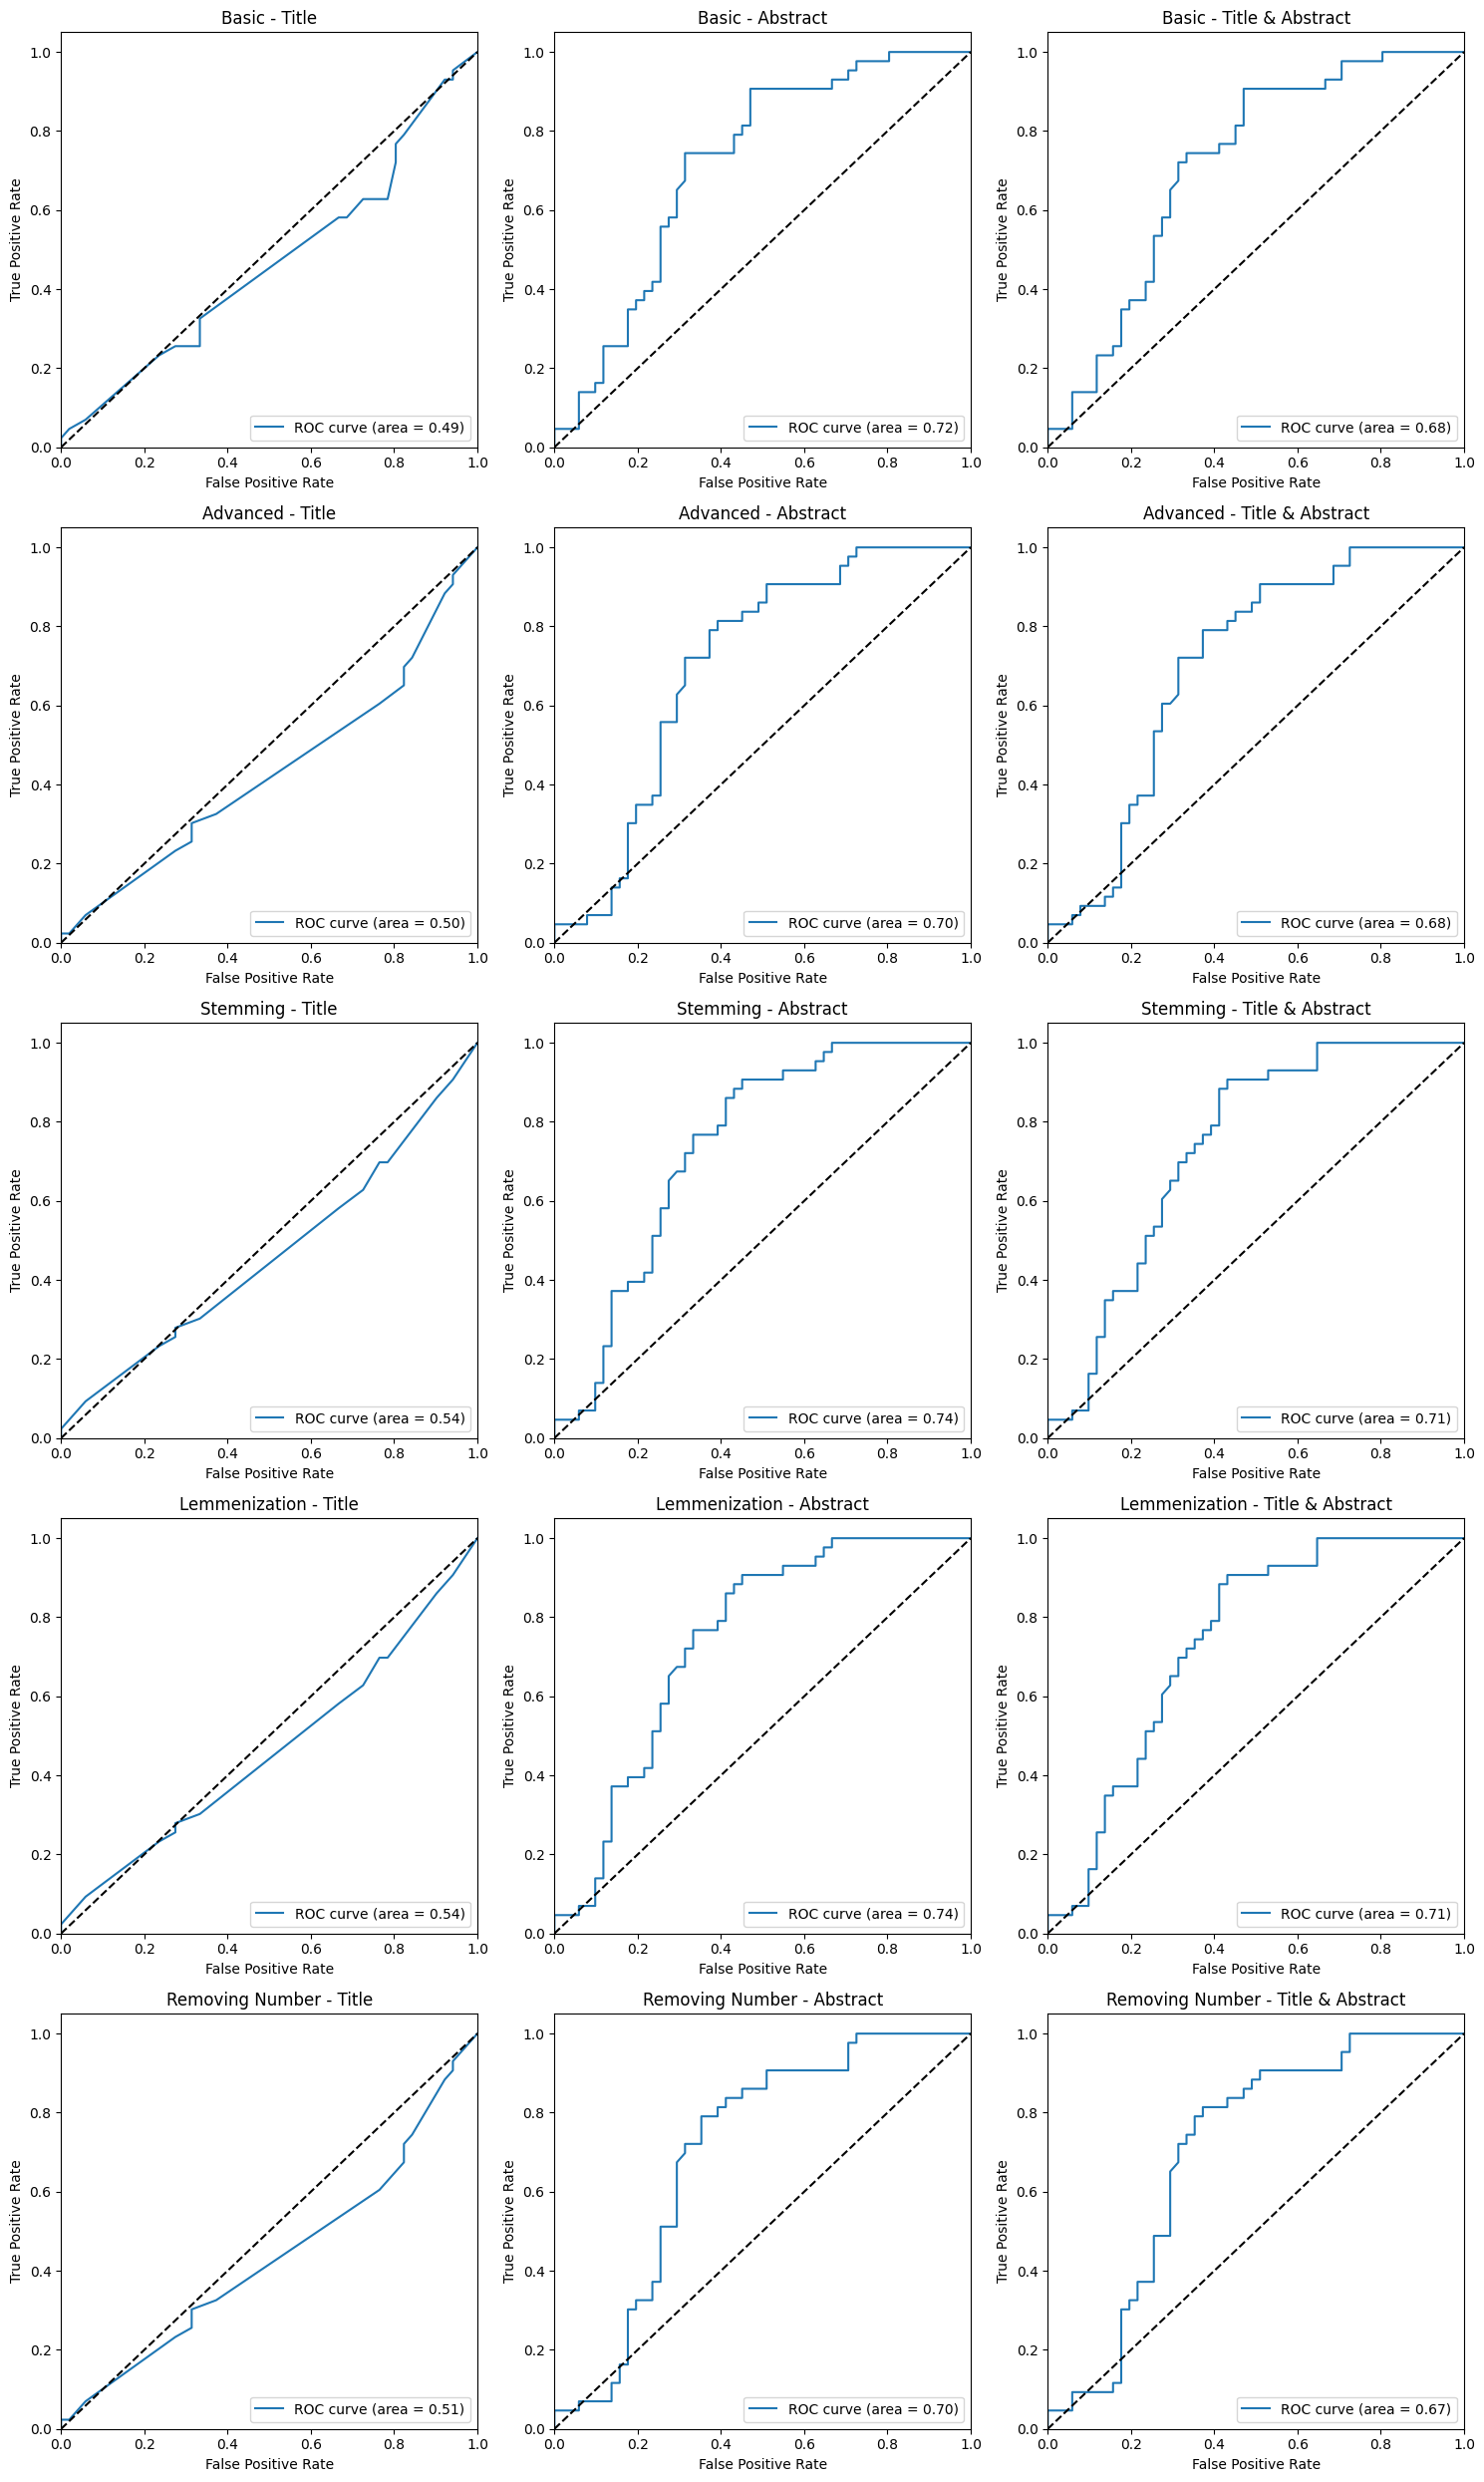

In [81]:
# Plot ROC curves
fig, axes = plt.subplots(5, 3, figsize=(15, 25))
axes = axes.flatten()

for i in range(5):
    for j, model in enumerate(["Title", "Abstract", "Title & Abstract"]):
        ax = axes[i*3 + j]
        fpr, tpr = roc_data_list[i][model]
        ax.plot(fpr, tpr, label=f'ROC curve (area = {results_df.loc[i*3+j, model]:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        data_cleaning_method = results_df.loc[i*3+j, 'Data Cleaning']
        ax.set_title(f'{data_cleaning_method} - {model}')
        ax.legend(loc="lower right")

plt.tight_layout()
plt.show()
